# IMDB - Word2Vec with LSTM
> ## NLP(Natural Language Processing)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Import Tensorflow

In [ ]:
import tensorflow

tensorflow.__version__

'2.15.0'

# I. IMDB Data_Set

> ## 1) wget From Github

* 'IMDB.zip' 파일 다운로드

In [ ]:
!wget https://raw.githubusercontent.com/rusita-ai/pyData/master/IMDB.zip

--2024-02-12 13:20:02--  https://raw.githubusercontent.com/rusita-ai/pyData/master/IMDB.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60711700 (58M) [application/zip]
Saving to: ‘IMDB.zip’

IMDB.zip            100%[===================>]  57.90M   166MB/s    in 0.3s    

2024-02-12 13:20:03 (166 MB/s) - ‘IMDB.zip’ saved [60711700/60711700]



* 다운로드 결과 확인

In [ ]:
!ls -l

total 59296
-rw-r--r-- 1 root root 60711700 Feb 12 13:20 IMDB.zip
drwxr-xr-x 1 root root     4096 Feb  8 14:21 sample_data


* Unzip 'IMBD.zip'

In [ ]:
!unzip -q /content/IMDB.zip

> ## 2) 'texts' and 'labels' Data

* 'texts': 문자열 리스트(영화 감상평)
* 'lebels': 감상평 리뷰(긍정/부정)

In [ ]:
import os

imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding = 'utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [ ]:
len(labels), len(texts)

(25000, 25000)

# II. Tensor Transformation

> ## 1) X_train and X_valid : (25000, 2000)

* vectorization
 - (25000, 2000)

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 2000               # 2000개 단어까지 적용
max_words = 10000           # 빈도 높은 10000개 단어 사용

tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('%s개의 고유한 토큰을 찾았습니다.' % len(word_index))

# (25000, 2000)으로 패딩
data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
print('데이터 텐서의 크기:', data.shape)
print('레이블 텐서의 크기:', labels.shape)


# 샘플 데이터 랜덤화
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


# 데이터를 훈련 세트와 검증 세트로 분할
training_samples = 15000            # 훈련 샘플은 15000개
validation_samples = 10000          # 검증 샘플은 10000개

X_train = data[:training_samples]
y_train = labels[:training_samples]
X_valid = data[training_samples: training_samples + validation_samples]
y_valid = labels[training_samples: training_samples + validation_samples]

88582개의 고유한 토큰을 찾았습니다.
데이터 텐서의 크기: (25000, 2000)
레이블 텐서의 크기: (25000,)


# III. Word2Vec

https://tfhub.dev/google/Wiki-words-250-with-normalization/2

> ## 1) Load Pretrained Word2Vec

In [ ]:
import tensorflow_hub as hub

embeddings_index = hub.load('https://tfhub.dev/google/Wiki-words-250/2')

* Word2Vec 매핑 확인

In [ ]:
embeddings_index(['apple'])

<tf.Tensor: shape=(1, 250), dtype=float32, numpy=
array([[-7.81319588e-02, -7.97718316e-02,  1.65636316e-02,
        -1.08001232e-02, -5.10360440e-03,  1.73767412e-03,
        -5.22104278e-02, -3.89753021e-02,  3.56903672e-02,
        -3.47909741e-02, -1.01491222e-02,  1.17565657e-03,
         1.01802059e-01,  1.75360963e-02,  3.36469710e-02,
         2.79656947e-02,  9.57141817e-02, -7.82085657e-02,
         5.06314561e-02, -1.66016668e-01,  2.88206208e-02,
         6.76635057e-02,  9.70917642e-02,  1.79236010e-02,
        -5.42766303e-02, -1.56506345e-01, -5.30809052e-02,
        -1.09254161e-03, -1.59554277e-02, -6.70691356e-02,
         6.15172908e-02,  4.47090678e-02,  4.07696068e-02,
        -3.83969024e-02,  6.96176291e-02, -5.60147781e-03,
        -2.26747449e-02, -3.67878452e-02, -5.66431917e-02,
        -2.18681507e-02, -8.86453837e-02, -2.22746611e-01,
        -2.07957737e-02,  8.30694276e-04, -3.93166617e-02,
         5.93367852e-02,  4.33623493e-02,  2.82799695e-02,
      

> ## 2) 임베딩 행렬 생성

* (10000, 250)

In [ ]:
%%time

embedding_dim = 250

embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index([word])
    if i < max_words:
        if embedding_vector is not None:
            # 임베딩 인덱스에 없는 단어는 모두 0이 됨
            embedding_matrix[i] = embedding_vector

CPU times: user 2min 33s, sys: 11.3 s, total: 2min 44s
Wall time: 2min 6s


* 확인

In [ ]:
embedding_matrix.shape

(10000, 250)

# IV. Keras Embedding Modeling

> ## 1) Model Define

* 모델 신경망 구조 정의
 - max_words: 10000
 - embedding_dim: 250

In [ ]:
from tensorflow.keras import models, layers

imdb = models.Sequential()

imdb.add(layers.Embedding(input_dim = max_words,
                          output_dim = embedding_dim))
imdb.add(layers.LSTM(32))
imdb.add(layers.Dense(1, activation = 'sigmoid'))

imdb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 250)         2500000   
                                                                 
 lstm (LSTM)                 (None, 32)                36224     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2536257 (9.68 MB)
Trainable params: 2536257 (9.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


> ### (1) <font color = 'blue'>'Word2Vec' Embedding Layer Parameter 설정

In [ ]:
imdb.layers[0].set_weights([embedding_matrix])

> ### (2) <font color = 'red'>'Word2Vec' Embedding Layer Parameter 동결

In [ ]:
imdb.layers[0].trainable = False

> ### (3) 모델 구조 확인

In [ ]:
imdb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 250)         2500000   
                                                                 
 lstm (LSTM)                 (None, 32)                36224     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 2536257 (9.68 MB)
Trainable params: 36257 (141.63 KB)
Non-trainable params: 2500000 (9.54 MB)
_________________________________________________________________


> ## 2) Model Compile

* 모델 학습방법 설정

In [ ]:
imdb.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

> ## 3) Model Fit

* 약 10분

In [ ]:
%%time

Hist_imdb = imdb.fit(X_train, y_train,
                     epochs = 100,
                     batch_size = 512,
                     validation_data = (X_valid, y_valid))

Epoch 1/100
30/30 [==============================] - 10s 211ms/step - loss: 0.6764 - accuracy: 0.5777 - val_loss: 0.6122 - val_accuracy: 0.6732
Epoch 2/100
30/30 [==============================] - 6s 188ms/step - loss: 0.6087 - accuracy: 0.6769 - val_loss: 0.5800 - val_accuracy: 0.7122
Epoch 3/100
30/30 [==============================] - 5s 173ms/step - loss: 0.5760 - accuracy: 0.7129 - val_loss: 0.5485 - val_accuracy: 0.7344
Epoch 4/100
30/30 [==============================] - 5s 176ms/step - loss: 0.5292 - accuracy: 0.7473 - val_loss: 0.5496 - val_accuracy: 0.7339
Epoch 5/100
30/30 [==============================] - 5s 177ms/step - loss: 0.4991 - accuracy: 0.7680 - val_loss: 0.4978 - val_accuracy: 0.7693
Epoch 6/100
30/30 [==============================] - 5s 178ms/step - loss: 0.5037 - accuracy: 0.7607 - val_loss: 0.4970 - val_accuracy: 0.7696
Epoch 7/100
30/30 [==============================] - 5s 177ms/step - loss: 0.4846 - accuracy: 0.7724 - val_loss: 0.4966 - val_accuracy: 0.767

> ## 4) 학습 결과 시각화

* Loss & Accuracy Visualization

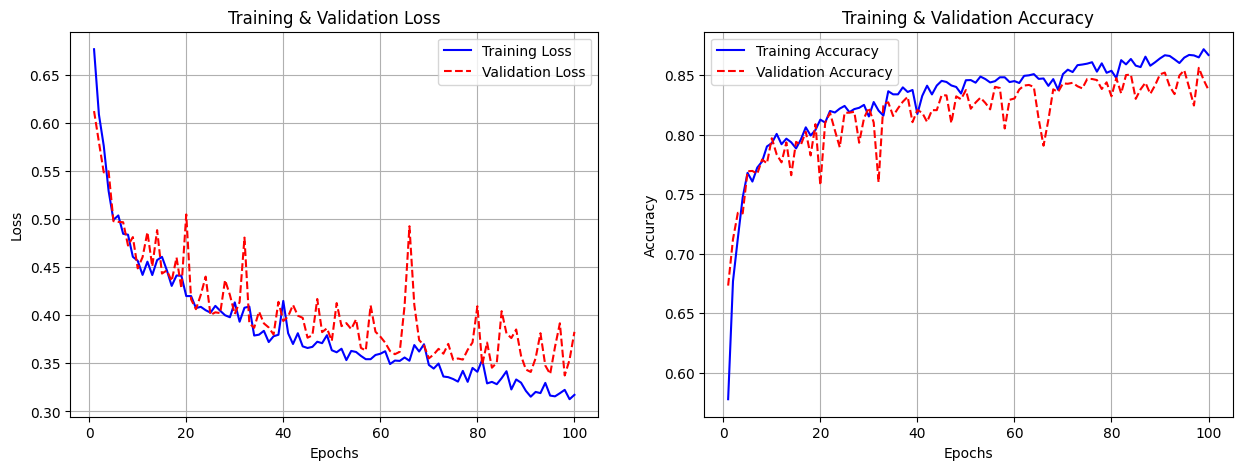

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_imdb.history['loss']) + 1)

plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, Hist_imdb.history['loss'], 'b-')
plt.plot(epochs, Hist_imdb.history['val_loss'], 'r--')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, Hist_imdb.history['accuracy'], 'b-')
plt.plot(epochs, Hist_imdb.history['val_accuracy'], 'r--')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()

plt.show()

> ## 5) Model Evaluate

* Loss & Accuracy

In [ ]:
loss, accuracy = imdb.evaluate(X_valid, y_valid)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

313/313 [==============================] - 8s 27ms/step - loss: 0.3827 - accuracy: 0.8377
Loss = 0.38272
Accuracy = 0.83770


# The End